# Modelling

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder

# Add the '../imports' directory to the sys.path list
import sys
sys.path.append('../imports')
from helper_functions import split_datetime
from actpred_plot import plot_actual_vs_pred
from data_preprocessing import merge_data, remove_col
from feature_engineering import * # this is bad practice, call functions explicitly


## Import Data

In [2]:
# Get the train data

DATA_DIR = "../data/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client_train = pd.read_csv(DATA_DIR + "client.csv")
historical_weather_train = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather_train = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity_prices_train = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas_prices_train = pd.read_csv(DATA_DIR + "gas_prices.csv")
weather_station_to_county_mapping = pd.read_csv(DATA_DIR + 'weather_station_to_county_mapping.csv')

## Data Preprocessing

In [3]:
# We merge all DataFrames 
merged_train_df = merge_data(train, client_train, historical_weather_train,
        forecast_weather_train, electricity_prices_train, gas_prices_train, weather_station_to_county_mapping)

In [4]:
# Drop all non needed columns (ids and timestamps)
model_df = remove_col(merged_train_df)

In [5]:
model_df

,county,is_business,product_type,target,is_consumption,eic_count_client,installed_capacity_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,...,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,year,month,week,hour,day_of_year,day_of_month,day_of_week
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,Wednesday
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,Wednesday
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,Wednesday
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,Wednesday
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,15.0,620.0,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,Wednesday
2018348,15,1,1,0.000,0,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,Wednesday
2018349,15,1,1,28.404,1,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,Wednesday
2018350,15,1,3,0.000,0,55.0,2188.2,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,Wednesday


## Train-Test-Split

In [6]:
X = model_df.drop('target', axis=1)
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Train the Model

We take the parameters from the model optimization (notebook 2.2)

In [7]:
model = XGBRegressor(enable_categorical=True, max_depth=9, learning_rate=0.3) 
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### conclusion on test/train split
- with the parameters set by grid search, the sizes of test and train data do not influence the quality of model results too much. 
- random state is not too important 
- using XGBoot's default parameters, the size makes a small difference. (Note: we did the grid search with all features, probably including ID columns...)

- Already here, we are overfitting!


## Evaluate Model

In [8]:
# Train Data

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# main optimisation metric
print('Mean absolute error test', mean_absolute_error(y_test, y_test_pred))
print('Mean absolute error train', mean_absolute_error(y_train, y_train_pred))

Mean absolute error test 32.6847620704102
Mean absolute error train 27.983228015027393


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

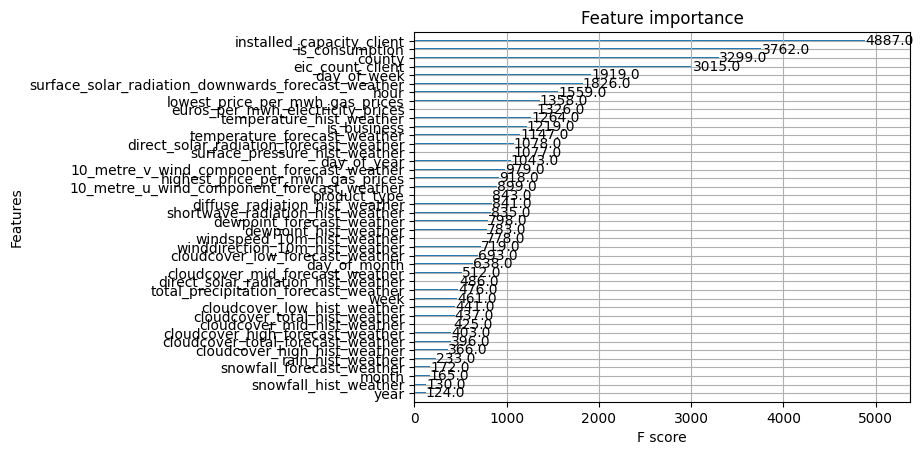

In [9]:
xgb.plot_importance(model)

- residuals are bigger at the summer time, we quess because production is happening at this time

- residuals on the test data have weekly pattern
- last two month predicted very poorly

- residuals are different depending on how we split our data 
- we see unexpalinable patterns in residuals
- residuals for consumption and production correlate with different features

- try residual analysis with traditional test_train_split

- tweak the model

> We tried to split the data into old and new data for training and testing. Because of bad scores we continue with a random train-test-split.

## Thinking: What features are important (or not)

- prices (should not influence consumption or production)

- we should check correlation heat maps to identify parameters that are highly correlated (although XGBoost seems to be able to handle correlated features well)
- this way we might be able to eliminate some weather related features that cover the same 'topic'


'county',                                   
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'eic_count_client',
 'installed_capacity_client',
 'lowest_price_per_mwh_gas_prices',             -> maybe drop the prices, we think prices correlate with season more than consumer behavior 
 'highest_price_per_mwh_gas_prices',
 'euros_per_mwh_electricity_prices',
 'temperature_hist_weather',
 'dewpoint_hist_weather',
 'rain_hist_weather',                           -> rain may be not too important (can only happen with cloud cover anyway, and cloud cover may 
 'snowfall_hist_weather',                               be a better feature)
 'surface_pressure_hist_weather',
 'cloudcover_total_hist_weather',            -> cloud cover influences solar radiation... is maybe redundant
 'cloudcover_low_hist_weather',                   drop other cloud covers and only keep total
 'cloudcover_mid_hist_weather',
 'cloudcover_high_hist_weather',
 'windspeed_10m_hist_weather',
 'winddirection_10m_hist_weather',
 'shortwave_radiation_hist_weather',
 'direct_solar_radiation_hist_weather',
 'diffuse_radiation_hist_weather',
 'temperature_forecast_weather',
 'dewpoint_forecast_weather',
 'cloudcover_high_forecast_weather',
 'cloudcover_low_forecast_weather',
 'cloudcover_mid_forecast_weather',
 'cloudcover_total_forecast_weather',
 '10_metre_u_wind_component_forecast_weather',
 '10_metre_v_wind_component_forecast_weather',
 'direct_solar_radiation_forecast_weather',
 'surface_solar_radiation_downwards_forecast_weather',
 'snowfall_forecast_weather',
 'total_precipitation_forecast_weather',
 'year',
 'month',
 'week',
 'hour',
 'day_of_year',
 'day_of_month',
 'day_of_week']                             -> seemed important in EDA and in feature importance plot    

## Feature selection and engineering

selected features, as found by the sequential feature selector in 02.2_Model_Optimization.ipynb:

['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

In [10]:
# hard-coded list of selected features, found by sequential feature selector

sel_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

In [11]:
def calc_mae_tst_trn(y_test, y_test_pred, y_train, y_train_pred):
    '''Calculates MAE for test and train data.'''
    
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    print('Mean absolute error test', mae_test)
    print('Mean absolute error train', mae_train)
    print('MAE Difference (test-train)', mae_test-mae_train)

In [12]:
def run_model(df):
    # Run model with selected features
    ## do stuff to model_df

    # train-test split
    X = df
    y = model_df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # training
    model = XGBRegressor(enable_categorical=True) 
    model.fit(X_train, y_train)

    # evaluation
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    calc_mae_tst_trn(y_test, y_test_pred, y_train, y_train_pred)

df = model_df.copy()
# only keep columns selected by SFS
cols = sel_features
df = df[cols]

run_model(df)

Mean absolute error test 49.1373023723616
Mean absolute error train 48.0469103636372
MAE Difference (test-train) 1.0903920087244003


> these are the best results so far (not in terms of absolute values for train, but in terms of preventing overfitting)

In [13]:
def calc_mae_prodcons(target_production, target_prediction_production, target_consumption, target_prediction_consumption):
    ''' Function that calculates MAE for production and consumption seperately
    '''
    print('Mean absolute error test production', mean_absolute_error(target_production, target_prediction_production))
    print('Mean absolute error test consumption', mean_absolute_error(target_consumption, target_prediction_consumption))

    print('Mean absolute percentage error test production', mean_absolute_percentage_error(target_production, target_prediction_production))
    print('Mean absolute percentage error test consumption', mean_absolute_percentage_error(target_consumption,target_prediction_consumption))

In [14]:
# get MAE for prod and cons separately

X_test_prod = X_test[X_test["is_consumption"] == 0]
y_test_prod = y_test[X_test["is_consumption"] == 0]
y_test_pred_prod = y_test_pred[X_test["is_consumption"] == 0]

X_test_con = X_test[X_test["is_consumption"] == 1]
y_test_con = y_test[X_test["is_consumption"] == 1]
y_test_pred_con = y_test_pred[X_test["is_consumption"] == 1]

calc_mae_prodcons(y_test_prod, y_test_pred_prod, y_test_con, y_test_pred_con)

Mean absolute error test production 22.40760063954274
Mean absolute error test consumption 42.96892052100117
Mean absolute percentage error test production 7139075121847439.0
Mean absolute percentage error test consumption 11082740402507.615


> predicting consumption is more accurate than predicting production (we have seen in EDA that there is a lot of fluctuation in production)

In [15]:
# Use the index of X_test to merge the target values back from the original dataset
X_test_with_target = X_test
X_test_with_target['target'] = y_test
X_test_with_target['predicted'] = y_test_pred

In [16]:
# X_test_with_target.query('is_consumption==0 & target == 0').describe().T

## Feature engineering

sel_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

IDEAS 
- holidays (christmas, easter, ...)
- workday vs weekend
- increasing in the capacity (??)
- weather aggregation for previous/future period
- prices aggregation for previous period (discard)

- daylight (or not), possibly boolean? ---> if false, set production 0
       - based on time, sunlight, cloudcover
       - essentially solar radiation should be enough, it already indicates if the sun is shining or not. 
- capacity per client ('eic_count' / )
- square the capacity, to give it a bigger weight (to exaggerate the trend in increasing capacity)
- some scale that represents the growth in capacity (could be different in the segments?)
- how much of the capacity is actually used at any time (capacity / production)

TO DO
- replace negative targets with 0 (neither production nor consumption can be negative)


Best so far (Vanessa/Sarah commit):
- Mean absolute error test 48.36763815779347
- Mean absolute error train 47.16665900818055
- MAE Difference (test-train) 1.2009791496129196

STEP 1: With dropping cloudcover and diffuse:
- Mean absolute error test 48.00836528113775
- Mean absolute error train 46.826012754281024
- MAE Difference (test-train) 1.1823525268567252

STEP2+STEP 3: With new col temp_dew:
- Mean absolute error test 47.46072403111012
- Mean absolute error train 46.24984824354659
- MAE Difference (test-train) 1.2108757875635305

### Experiments

In [17]:
model_df = add_daylight_col(model_df)

model_df = add_capacity_col(model_df)

model_df = basic_improvements(model_df)


In [18]:
model_df

,county,is_business,product_type,target,is_consumption,eic_count_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,temperature_hist_weather,...,week,hour,day_of_year,day_of_month,day_of_week,daylight,capacity_per_eic,squared_capacity_client,sum_column,temp_dew
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,35,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,35,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,35,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,35,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,35,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,15.0,29.0,34.0,-1.29,11.18,...,22,23,151,31,Wednesday,False,41.33,384400.00,0.0,77.500963
2018348,15,1,1,0.000,0,20.0,29.0,34.0,-1.29,11.18,...,22,23,151,31,Wednesday,False,31.22,390000.25,0.0,77.500963
2018349,15,1,1,28.404,1,20.0,29.0,34.0,-1.29,11.18,...,22,23,151,31,Wednesday,False,31.22,390000.25,0.0,77.500963
2018350,15,1,3,0.000,0,55.0,29.0,34.0,-1.29,11.18,...,22,23,151,31,Wednesday,False,39.79,4788219.24,0.0,77.500963


In [19]:
# We have to change the list of selected features

selected_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week','daylight', 'capacity_per_eic',
       'squared_capacity_client', 'sum_column', 'temp_dew'
]

In [20]:
# train-test split
X = model_df.drop("target", axis=1)[selected_features]
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# training
model = XGBRegressor(enable_categorical=True) 
model.fit(X_train, y_train)

# evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

calc_mae_tst_trn(y_test, y_test_pred, y_train, y_train_pred)

Mean absolute error test 47.515057300563946
Mean absolute error train 46.501235997796435
MAE Difference (test-train) 1.0138213027675107


## More Feature Engineering

In [21]:
def add_shifted_target(df:pd.DataFrame)->pd.DataFrame:
    # reintroduce the datetime column for merging
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day_of_month', 'hour']].rename(columns={'day_of_month' : 'day'}),format='%Y:%m:%d:%h')
    # make copy of the needed columns
    shifted_df = df[['county', 'is_business', 'product_type', 'is_consumption','datetime', 'target']].copy()
    # rename the target as shifted_target - that is the new column we want to add
    shifted_df.rename(columns={'target' : 'shifted_target'}, inplace=True)
    # shift the datetime by two days for our helper df
    shifted_df["datetime"] = shifted_df["datetime"] + pd.Timedelta(2, unit="days")
    # merge the shifted df to our original df - match the target of today to the day two days ahead 
    df = pd.merge(df, shifted_df, on= ['county', 'is_business', 'product_type', 'is_consumption','datetime'], how='left')
    # drop the datetime column again
    df.drop("datetime", axis=1, inplace=True)
    return df

In [64]:
test = model_df.copy()

In [65]:
test = add_shifted_target(test)

In [ ]:
test.tail()

In [ ]:
test['datetime'] = pd.to_datetime(test[['year', 'month', 'day_of_month', 'hour']].rename(columns={'day_of_month' : 'day'}),format='%Y:%m:%d:%h')
test.groupby(['county', 'is_business', 'product_type', 'is_consumption','datetime'])[["target", "shifted_target"]].sum().tail(52)

2023-05-29 20:00:00	267.423	141.646  
2023-05-29 21:00:00	296.073	172.973  
2023-05-29 22:00:00	299.806	190.316  
2023-05-29 23:00:00	177.056	183.756  

In [66]:
# train-test split

# We have to change again the list of selected features

selected_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week','daylight', 'capacity_per_eic',
       'squared_capacity_client', 'sum_column', 'temp_dew', 'shifted_target'
]

X = test.drop("target", axis=1)[selected_features]
y = test['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# training
model = XGBRegressor(enable_categorical=True) 
model.fit(X_train, y_train)

# evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

calc_mae_tst_trn(y_test, y_test_pred, y_train, y_train_pred)

Mean absolute error test 44.79870097080926
Mean absolute error train 43.13469007753432
MAE Difference (test-train) 1.6640108932749342


Last scores:  
Mean absolute error test 47.515057300563946  
Mean absolute error train 46.501235997796435  
MAE Difference (test-train) 1.0138213027675107  

> Small improvement but bigger gab

## Encoding

In [67]:
category_list = ['product_type', 'county']

In [68]:
prepro_df = model_df.copy()

In [69]:
prepro_df = add_shifted_target(prepro_df)
prepro_df

,county,is_business,product_type,target,is_consumption,eic_count_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,temperature_hist_weather,...,hour,day_of_year,day_of_month,day_of_week,daylight,capacity_per_eic,squared_capacity_client,sum_column,temp_dew,shifted_target
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,0,244,1,Wednesday,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,15.0,29.0,34.0,-1.29,11.18,...,23,151,31,Wednesday,False,41.33,384400.00,0.0,77.500963,188.167
2017820,15,1,1,0.000,0,20.0,29.0,34.0,-1.29,11.18,...,23,151,31,Wednesday,False,31.22,390000.25,0.0,77.500963,0.000
2017821,15,1,1,28.404,1,20.0,29.0,34.0,-1.29,11.18,...,23,151,31,Wednesday,False,31.22,390000.25,0.0,77.500963,31.484
2017822,15,1,3,0.000,0,55.0,29.0,34.0,-1.29,11.18,...,23,151,31,Wednesday,False,39.79,4788219.24,0.0,77.500963,0.000


In [70]:
enc = OneHotEncoder(handle_unknown='ignore', drop='first')
encoded_categories = enc.fit_transform(prepro_df[category_list])

In [71]:
# Convert the encoded sparse matrix to a DataFrame with meaningful column names
encoded_df = pd.DataFrame(encoded_categories.toarray(), columns=enc.get_feature_names_out(category_list))

# The result will be a new DataFrame with binary columns for each category
encoded_df

,product_type_1,product_type_2,product_type_3,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017821,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017822,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
prepro_df = pd.concat([prepro_df, encoded_df], axis=1)
prepro_df

,county,is_business,product_type,target,is_consumption,eic_count_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,temperature_hist_weather,...,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017819,15,1,0,197.233,1,15.0,29.0,34.0,-1.29,11.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017820,15,1,1,0.000,0,20.0,29.0,34.0,-1.29,11.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017821,15,1,1,28.404,1,20.0,29.0,34.0,-1.29,11.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017822,15,1,3,0.000,0,55.0,29.0,34.0,-1.29,11.18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
selected_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week','daylight', 'capacity_per_eic',
       'squared_capacity_client', 'sum_column', 'temp_dew', 'shifted_target'
]

In [74]:
selected_features = [I for I in selected_features if I not in category_list]

In [75]:
selected_features = selected_features + enc.get_feature_names_out(category_list).tolist()
selected_features

['is_business',
 'is_consumption',
 'eic_count_client',
 'surface_solar_radiation_downwards_forecast_weather',
 'total_precipitation_forecast_weather',
 'year',
 'week',
 'hour',
 'day_of_year',
 'day_of_week',
 'daylight',
 'capacity_per_eic',
 'squared_capacity_client',
 'sum_column',
 'temp_dew',
 'shifted_target',
 'product_type_1',
 'product_type_2',
 'product_type_3',
 'county_1',
 'county_2',
 'county_3',
 'county_4',
 'county_5',
 'county_6',
 'county_7',
 'county_8',
 'county_9',
 'county_10',
 'county_11',
 'county_12',
 'county_13',
 'county_14',
 'county_15']

In [76]:
# train-test split

# We have to change again the list of selected features

X = prepro_df.drop("target", axis=1)[selected_features]
y = prepro_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# training
model = XGBRegressor(enable_categorical=True) 
model.fit(X_train, y_train)

# evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

calc_mae_tst_trn(y_test, y_test_pred, y_train, y_train_pred)

Mean absolute error test 44.96391147879263
Mean absolute error train 43.49426323664618
MAE Difference (test-train) 1.4696482421464552


Last scores:  
Mean absolute error test 44.79870097080926  
Mean absolute error train 43.13469007753432  

> No improvement for OneHotEncoded.

## Error Analysis

In [ ]:
numeric_columns = model_df[sel_features].select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def error_analysis(y_test, y_test_pred):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_test_pred
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_test_pred, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, y_test_pred.max()+10], [-400, y_test_pred.max()+10], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    # ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    # ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    ax[0].set_xlim((y_test_pred.min()-10), (y_test_pred.max()+10))
    ax[0].set_ylim((y_test_pred.min()-10), (y_test_pred.max()+10))


    ax[1].scatter(y_test_pred, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, y_test_pred.max()+10], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_test_pred.min()-10), (y_test_pred.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

In [ ]:
error_analysis(y_test, y_test_pred)

looking good!